In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full.columns[8:12])
cols = y_cols.copy()
cols.insert(0,'x')
data_df = data_df_full[cols].copy()
data_df.head(10)

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,39,7,0,3
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,1,1,24,154
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,4
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1,0,59,7
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,16


In [3]:
X = data_df['x']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=4


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
                                              alphabet=alphabet,
                                              number_latent_nodes=2)



In [7]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [8]:
print(N_y)

TiteSeq_01_bin1    2579236
TiteSeq_01_bin2    1157805
TiteSeq_01_bin3    1626103
TiteSeq_01_bin4    5929980
dtype: int64


#### I approximated these values from Fig 2B

In [9]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP

In [10]:

mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [11]:
mu_neg, sigma_neg

(50, 100)

In [12]:
f_y_upper_bounds

array([   180,   1400,  10500, 250000])

In [13]:
#np.arange(10**(-13),10**(-6),10**(-12))
cs = [0,10**(-13),10**(-12.5),
     10**(-12),10**(-11.5),
     10**(-11),10**(-10.5),
     10**(-10),10**(-9.5),
     10**(-9),10**(-8.5),
     10**(-8),10**(-7.5),
     10**(-7),10**(-6.5),
     10**(-6)]

#cs = np.arange(0.1,1,0.06)

In [14]:
TiteSeq_mp = mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y,
                                                         c=1e-6,
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-5,
                                                         )

In [15]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[TiteSeq_mp])

2022-05-24 13:31:01.655481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4225)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4221)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 multi__additive_gp_map_layer (  (None, 2)           8444        ['Sequence_only[0][0]']          
 Multi_AdditiveGPMapLayer)                                                                        
                                                                                              

In [17]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,                                                       
                      ],

               shuffle=False)

N = 74,560 observations set as training data.
Using 20.2% for validation.
Time to set data: 10.1 sec.


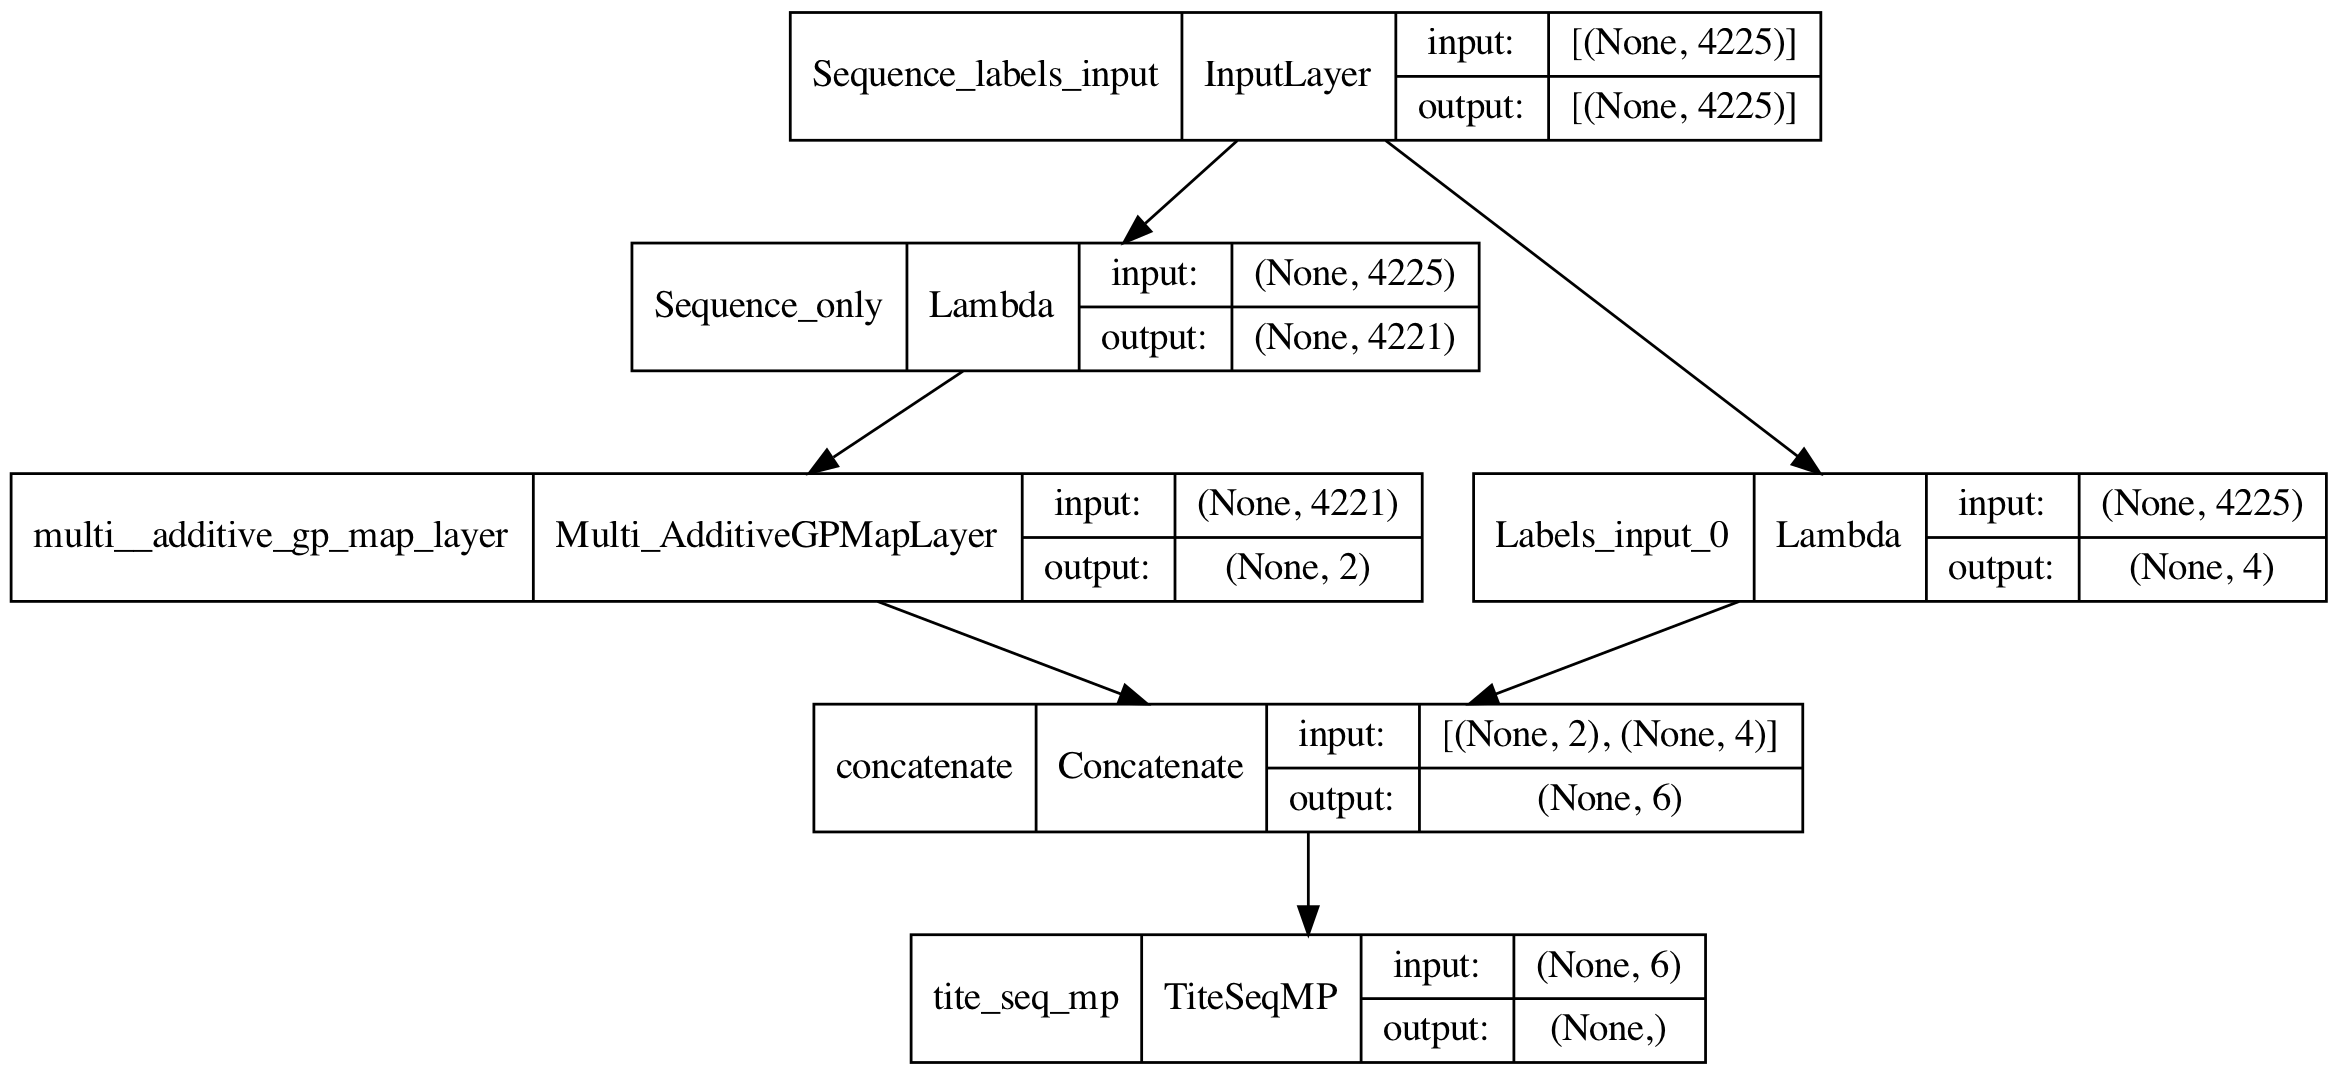

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='titeseq_mp_singlehead.png')

In [19]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=1000,
          batch_size=250,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/1000
239/239 [==============================] - 4s 15ms/step - loss: 405830.4688 - I_var: -18.2368 - val_loss: 401870.5625 - val_I_var: -17.8809
Epoch 2/1000
239/239 [==============================] - 2s 10ms/step - loss: 401403.7812 - I_var: -17.9566 - val_loss: 401692.5625 - val_I_var: -17.8684
Epoch 3/1000
239/239 [==============================] - 2s 10ms/step - loss: 401175.2500 - I_var: -17.9591 - val_loss: 401619.3750 - val_I_var: -17.8638
Epoch 4/1000
239/239 [==============================] - 3s 11ms/step - loss: 400978.7500 - I_var: -17.9980 - val_loss: 401774.0625 - val_I_var: -17.8704
Epoch 5/1000
239/239 [==============================] - 2s 10ms/step - loss: 400926.2500 - I_var: -17.9928 - val_loss: 401464.4375 - val_I_var: -17.8560
Epoch 6/1000
239/239 [==============================] - 2s 9ms/step - loss: 400830.2188 - I_var: -17.9524 - val_loss: 401411.3125 - val_I_var: -17.8528
Epoch 7/1000
239/239 [==============================] - 2s 9ms/step - loss: 400806.

239/239 [==============================] - 2s 8ms/step - loss: 400520.5000 - I_var: -17.9300 - val_loss: 401342.7812 - val_I_var: -17.8483
Training time: 117.7 seconds


On test data:


Text(0.5, 1.0, 'training hisotry')

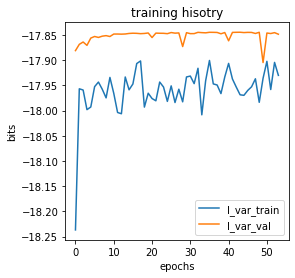

In [20]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [21]:
#phi = gpmap.x_to_phi(x_test)
gpmap.weights[1].numpy().shape

(1, 2, 201, 21)

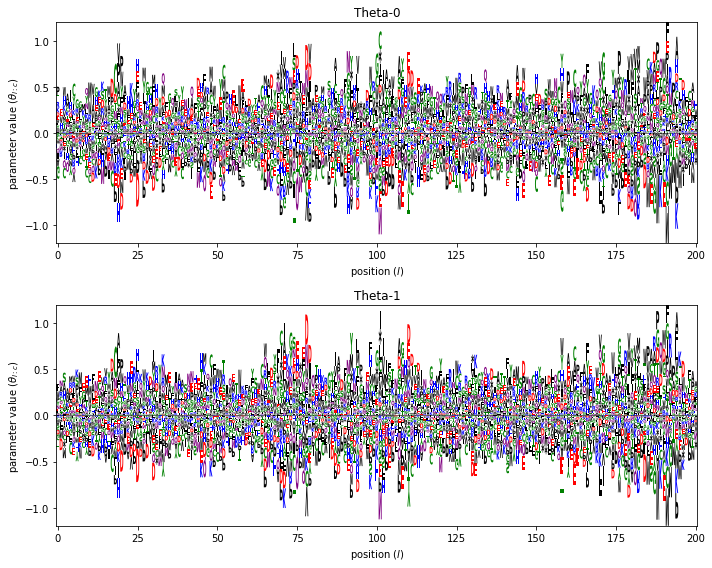

In [22]:
# Get G-P map parameters in matrix form
theta_0 = np.squeeze(gpmap.weights[1].numpy()[0][0])
theta_1 = np.squeeze(gpmap.weights[1].numpy()[0][1])

# Create grid in phi space
#phi_lim = [-5, 3]
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = 10    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = sortseq_mp.p_of_all_y_given_phi(phi).numpy()
# measurement_process_2 = mp_mpa_2.p_of_all_y_given_phi(phi).numpy()
# measurement_process_3 = mp_mpa_3.p_of_all_y_given_phi(phi).numpy()

#measurement_process = np.hstack([measurement_process_1,measurement_process_2,measurement_process_3])

# Create figure with two panels
fig, axs = plt.subplots(2,1,figsize=[10,8])

ax = axs[0]
# Left panel: draw logo using logomaker
logo = logomaker.Logo(pd.DataFrame(theta_0,columns=model.alphabet), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('Theta-0')

ax = axs[1]
logo = logomaker.Logo(pd.DataFrame(theta_1,columns=model.alphabet), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('Theta-1')


# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(np.sort(measurement_process,axis=0).T,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('sortseq_g-p_map_mpa_visualization.png')
plt.show()

In [23]:
# # Create grid in phi space
# phi_lim = [-5, 5]
# phi_grid_1d = np.linspace(phi_lim[0], phi_lim[1], 1000)
# phi_grid = np.array([phi_grid_1d,phi_grid_1d])

# # Create array of allowable y values
# Y = TiteSeq_mp.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# # Compute matrix of p(y|phi) values
# measurement_process = TiteSeq_mp.p_of_y_given_phi(y_all, phi_grid)


# # Create figure with two panels
# fig, ax = plt.subplots(1,1,figsize=[6,6])

# # Right panel: draw measurement process as heatmap
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('Sort-seq measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
